In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pickle
with open("/content/gdrive/MyDrive/labels.pkl",'rb') as f:
    x = pickle.load(f)
    print(x)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from sklearn.metrics import classification_report
#from keras.applications import ResNet50
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
from keras.models import Model

LABELS = set(["Crown and Root Rot","Fusarium Head Blight","Healthy Wheat","Leaf Rust","powdery mildew","Tan Spot","Wheat Loose Smut"])

In [ ]:
with open("/content/gdrive/MyDrive/dataset.pkl",'rb') as f1:
    d = pickle.load(f1)
    print(d.shape)

(5272, 224, 224, 3)


In [ ]:
from sklearn.utils import shuffle
X_shuffled,y_shuffled = shuffle(d, x, random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(X_shuffled, y_shuffled,
                                                  test_size=0.2, stratify=y_shuffled, random_state=42)

trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean

valAug.mean = mean


In [ ]:
print(trainX.shape)

(4217, 224, 224, 3)


In [ ]:
X_train = trainX.reshape(4217, 150528)


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm=SMOTE(random_state=42)
x_smote, y_smote=sm.fit_resample(X_train,trainY)

In [ ]:
print(x_smote.shape)

(7161, 150528)


In [ ]:
print(y_smote.shape)

(7161, 7)


In [ ]:
smote_x=x_smote.reshape(7161,224, 224, 3)

In [ ]:
from keras.applications.resnet import ResNet50, preprocess_input
pretrained_model= ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=7,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False


94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#from tensorflow.keras import layers,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))
resnet_model.summary()
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 1,052,679
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = resnet_model.fit(trainAug.flow(smote_x, y_smote, batch_size=64), validation_data = valAug.flow(testX, testY), steps_per_epoch = 62, epochs=150)

Epoch 1/150
62/62 [==============================] - 64s 777ms/step - loss: 1.1120 - accuracy: 0.6425 - val_loss: 0.6442 - val_accuracy: 0.7839
Epoch 2/150
62/62 [==============================] - 45s 729ms/step - loss: 0.6389 - accuracy: 0.7772 - val_loss: 0.5843 - val_accuracy: 0.8209
Epoch 3/150
62/62 [==============================] - 46s 737ms/step - loss: 0.5189 - accuracy: 0.8200 - val_loss: 0.5845 - val_accuracy: 0.8171
Epoch 4/150
62/62 [==============================] - 46s 735ms/step - loss: 0.4836 - accuracy: 0.8324 - val_loss: 0.5357 - val_accuracy: 0.8190
Epoch 5/150
62/62 [==============================] - 45s 731ms/step - loss: 0.4690 - accuracy: 0.8346 - val_loss: 0.4439 - val_accuracy: 0.8559
Epoch 6/150
62/62 [==============================] - 47s 759ms/step - loss: 0.3974 - accuracy: 0.8609 - val_loss: 0.4543 - val_accuracy: 0.8474
Epoch 7/150
62/62 [==============================] - 45s 730ms/step - loss: 0.3810 - accuracy: 0.8685 - val_loss: 0.4552 - val_accuracy:

In [ ]:
lb = pickle.loads(open("/content/lb", "rb").read())

In [ ]:
predictions = resnet_model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))

                      precision    recall  f1-score   support

  Crown and Root Rot       0.97      0.99      0.98       204
Fusarium Head Blight       1.00      1.00      1.00        74
       Healthy Wheat       0.97      0.91      0.94       229
           Leaf Rust       0.93      1.00      0.96       256
            Tan Spot       0.92      0.62      0.74        55
    Wheat Loose Smut       0.93      0.96      0.95       186
      powdery mildew       0.98      1.00      0.99        51

            accuracy                           0.95      1055
           macro avg       0.96      0.93      0.94      1055
        weighted avg       0.95      0.95      0.95      1055



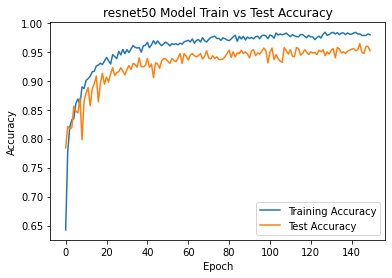

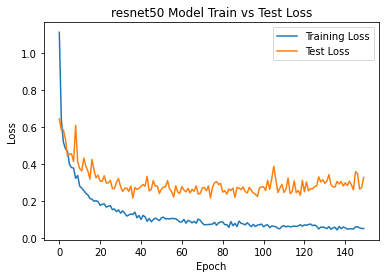

<Figure size 432x288 with 0 Axes>

In [ ]:
N = 150
plt.plot(np.arange(0, N), history.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), history.history['val_accuracy'], label="Test Accuracy")
plt.title('resnet50 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig(r"/content/Accuracy_Plot.png")
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.title('resnet50 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig(r"/content/Loss_Plot.png")

In [ ]:
# save the model to disk
resnet_model.save("7wheat_deseases_Resent50_model.h5")

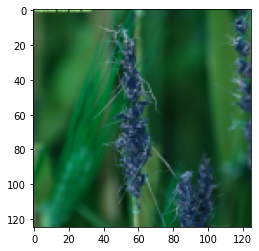

PREDICTION: WHEAT LOOSE SMUT


In [ ]:
from keras.models import load_model
from collections import deque
from matplotlib import pyplot as plt
model_path = "/content/7wheat_deseases_Resent50_model.h5"
input = "https://assets.syngenta.ca/images/pest/125/cda_loose_smut_barley_alternate3.png"
label = "/content/lb"
# load the trained model and label binarizer from disk
moodel = load_model(model_path)
lb = pickle.loads(open(label, "rb").read())
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input)
(W, H) = (None, None)
ii=0
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    text = "PREDICTION: {}".format(label.upper())
    cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_SIMPLEX,0.25, (200,255,155), 2)
    # show the output image
    image=cv2.resize(output,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    plt.show()
    print(text)
    key = cv2.waitKey(10) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
vs.release()

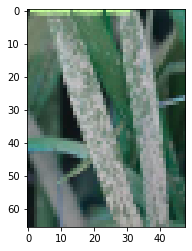

PREDICTION: POWDERY MILDEW


In [ ]:
from keras.models import load_model
from collections import deque
from matplotlib import pyplot as plt
model_path = "/content/7wheat_deseases_Resent50_model.h5"
input = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ0IQoMFUWox12xqSaNznAWoToWCuBcR8tMIg&usqp=CAU"
label = "/content/lb"
# load the trained model and label binarizer from disk
moodel = load_model(model_path)
lb = pickle.loads(open(label, "rb").read())
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input)
(W, H) = (None, None)
ii=0
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    text = "PREDICTION: {}".format(label.upper())
    cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_SIMPLEX,0.25, (200,255,155), 2)
    # show the output image
    image=cv2.resize(output,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    plt.show()
    print(text)
    key = cv2.waitKey(10) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
vs.release()

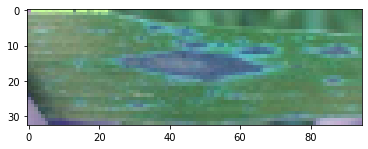

Crown and Root Rot
2.6713482537132904e-07
Fusarium Head Blight
6.574531804220736e-17
Healthy Wheat
2.2852933087569305e-09
Leaf Rust
5.7546611920145097e-08
Tan Spot
100.0
Wheat Loose Smut
8.034143489377144e-09
powdery mildew
3.9290372171041366e-10
PREDICTION: TAN SPOT


In [ ]:
from keras.models import load_model
from collections import deque
from matplotlib import pyplot as plt
model_path = "/content/7wheat_deseases_Resent50_model.h5"
input = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgVFhUZGRgaGBgYGBocFhUZGBUYGBgZGRgYGBgcIS4lHB4rHxgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHhISHzQkJCE0NDQ0NDE0NDE0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0ND80NDQ0NDQ0PzQ0Pz8xPzQxNDQ0Mf/AABEIAIUBewMBIgACEQEDEQH/xAAaAAACAwEBAAAAAAAAAAAAAAADBAABAgUG/8QAOBAAAQMCAggCCAYDAQEAAAAAAQACEQMhBDESQVFhcYGRoQUTIjJCUpKxwdEUFYKi4fBicvFDU//EABkBAQEBAQEBAAAAAAAAAAAAAAIBAAMEBf/EACQRAAICAgMAAgIDAQAAAAAAAAABAhEhMQMSQRNRBGEiMoEU/9oADAMBAAIRAxEAPwD0Us/+jehVGpT9/wDaVzxSKjqTkHN2F88hvz6Zzc74R91HmmL6buglJaCyWnWt2ZPnmNOq0hrf0Cy59Ij2/wBqAAdoWahcUZWH5pfZYw9Bxu+o39LSl6uDp/8A0d8H8rdRpF4KwwEm3dDqznYNuEZqqfsP3VtwAJtVbza4fRae17ScxwQ9I60OrI2FbgyLB7CeLvsijCvy9E/qH1SrKh1GFbnkkyZ+RRakZSNV8G+PUPIT8lzqmFcM2uHEEJ1tcjZ1KdZ4o8gDTduvKlsqkjisRQu4zFMJPmMaTtgT1Co4Km8+i0Bu0Pgj9Lgfmi5r3B1Ss4FUJVy9RX8BbHoVQdzhB6iVycT4RUGRY7g77wspxb2FxaOQ5W0pqp4bVHsOPCD8ks+g9vrNcOIK67IMUii6KSpvum2VEZJmCMYn8MzJINen8O5c8kY2KaXxDbJpjwg4kLWE5crTHoWIsUNj7prKGmPOFku5Ga6yXrFUlitZywAh1XozDZYa0CcxDcE0QsaCqYGGwjF2aGS5NGydZVgKXkNj73wFzsRWurqVlzqzrrbKwnmXTmHK5sroYZGSKh9izVK0xDroIb0IV0Jput4gpYOuu3gGNALMKMciNagRir23WpRn01ny0kZI7IpknMphlFzb3PUodJ7h6WlIR2Y8D2Sea7uSXglVg3UHm8E/JZOFcbFp6/ymX49xFrc0o6q6ZkqKX6NKgDqEGM+a2Kf+PfNZLHXMlU4u94pYYDTzqAI5rHku913dZDiNd0Q1akTpn7Iv9CVegn0XjU/uglp2num24x4EaZPFZNdxysY2AoSbNUX6KBrt6sh3HkF0fPbGeq9sylBXDcgTzMIJtl6xrYB74j0R3+iMyqXCAwcUGtXB9nohNde0jgrWDn6MOIBgtM8QsGoJtI/vFZqPcTBN1umw656ItFHcFiCCL9fuj4rxFjfRlulsNp4LluMGJAg6wnaTw65DSRrIBK4Shmz0cUktmWY9js25GJbIcE7Tp6fqPdwcgeaWGzWelrAlQ+IuBggA7oCjTWhylxPaN4jBv9qm12/RaUt+CGukBycPqn6eO0snxxuhVH1/ZLXcIWUpekjxQllMQr02MguY1oOUucPqtENA0gy3+xUDamTmTruJ+YTLCXDRNMgcYWtln+MqwxYY5o9n9yj8Yw5tPIo1Tw1pk3GvUkn0NG47pxkpHllFx2VVNN3vDoVgUGe+74QhOaTcR3UYyTcgJ69Am0Ntps9/q0odXCg5Pb3S7zFgZC2x8aptrVtmsVq+GP1Fh/WFtnh9QezPBzT9Vp9czlC02tvhVti7tFMwr9bD0WjhXe674SiMxH+XzCKzxF7cnd1LZO1i3lnYehWC9dT8ye4XqHhohL/jHE3cpZrEi9Aeuqccdx5BV+O3A/oZ9krL2Ryl0cLkE2MV/gzmxv2W6WKA/wDNnwoSlYk0aahVk43xGjkaN9xP3VOxeHdnTcODz9UIjtfZw8QEm7NeiczDPOb282lY/K8M4wKr/hYu0ZL7C0cZjk3TKed4RRH/ALO+Bv3WmYKiP/Z3wD7rNojTE3NVaKadTp6nuP6B91Wiz3j0/lZSRLXow0apKLTwpOXzC57Gvn1iUdriNZ6r0tMSr0adTcLEEILxxWHPcciTzQ9E656qLZH+g5kBUWO3oOhvPVW4kjM23pBNlp3qnHjPZDaz/I9QoGazPxLPRitA5rLnx/xW5hJ1gbih6DhrPNQhsutl90I71ZY861UuFpQbRjECckchkDPshscQPVbPNF85hHpMvu/4g6FFCznAHXmncPXaRBjilHlkH0Tu/wCLAYBFzfaLdlOqZsxdjrGtAOk7S5ARzSzm3tA5ofA9v4VFu9Hql6VycmFfSIvfdmsaJOtEbXeW6M2QmNcNvZELT8HaODLhIgKVH6Fi+DulShXeNRjgiu0HRpMvzXNp3bPRxqNZQXD4pwB9PqrfUefanos18KHNGhbjsSX5e9xsb7nI9Yt4Z6fjTWwxqzI08tQIkcks6g83bcJuj4PU1wBtJEninsHhPL9Z4A2Ays2o6Oc+FNbORRpvBmIjcpXYTnHRd5+Jp5TnmkG4Whph2m+xmJt0QXI/o4rih9nJFOMwnKNBhEzG6V0cSxjzYjkUL8tIM6VuU9FflsEePOMi1TCgCAwunWJsl8TgdEaQPLWulVpMF9MjslazqcRpknkrGUrO0uFyWEcssGshbptmcm269kbTpzGg49vonG4qgImn1dP0XXu/o5/8kzlaMa0xRYzNzhwldM1sNmLbolDdgw/0mugcIQfJeHaC+GUHbViGIDJ9H5yqp1ANUrWIpaJ9ZLTvPVdErRxbtnSe4R6QI/V9kvQqsYTAJn3iT0lDbReRrvvK6NHCM0R5h0T/ALC65uo7OkU5YQpWx4cI0ec5JTzeK67/AAuTIdbVdBfgGN9d8dU4uKWCfFJvQgysRqlb05M5crJ+l+HB9YnkbrOJq0zIY2+9ZO3o6R4JsSLjt7D7Kg8/2Exh6gHrs6FOMZQfYODTvhVutosvx5I5zTtWvR/oXQq+Gw2Q4EbrpDyju6LKUWcWmsM3TxBAjR4a0d+JdA9AJGniDsC1+KJOXdexsbHm4qBAYOv8LNSuXC7RbYUqMRtCj8Tu7o2kS2GFbd3VGv8A490FtedUcEQEG5Jngs5pEaNtqa9Huo1591EosaUVjRDjBBG4rm+UcYWrBPe2AQ2Of0QM9394oj6gOc7hCA6pGZhZclhaSLe8agZQmnj0KOys3Ve2ZGSNSrMyKMuRo1JimjKNSwsgybpxz2RaeQS+Jfb0S6DrII7oLkcv0eiHDF5sD+FF/S7WWfJblpjr9ELRBtpX16v+rRY2NXaV0abR0fDAaboNHpGZtYSieZTAsCf0lctgB1droxptEZTvJCHS9jXFFIZq4toyYAssxWxoGvM35LLNE6mx/sVt1IzaOOml8aoqUfoXqVXukA24IDmGMyTumF0m0jF55EKxRGjbS4wCqooWjk4d9S4JIjKD9U0zFVG+1HRG8vXeP0qGkCJkg8FHH9CUgb/E6w9sdPohP8RqHMA8kd+EIA9L9pStRhBzaeRQcI/RmlLYZmLB9ZhHA/dEGLpC8uHIFIFpV8go+NA+KH0dWljac2cfhXTZXpECXieK8s+2S1TqHXPT+VzfDeixhGOj0mJ8Ia++m6DvkIH5EBcPPNs/VI4XxIsOZcIyK6bPGGOtccrIShyR0ytyWhMeAw6fOB2iD90V3gjIPp9h90y5oNw63FLvoOudI9VO0ntnCXJNeCwwNNpuSf7xTTqhAhrRHJJmg7WVgUXH2j3Tq9s4S5Zy2Dr1ATcFBjWGp5uE9EuJjVEXKU0DsK6xwsHnd2bp1IEyZ2XRGYonMSgFvFbe0xYHitViUpLQ1+aHZZR9djxeQueWTrhWRGuVOolzSQ+3BNPqvA3GyGfDnTIaJP8AmClS9w1hGL3ATKyclizovyZeocb4c4j0nAHihswzGulz+yU88kZ91Wlt+aX8n6Z/kv6O6cYzRgLn1AJNwkw1sZqtHd3W6s5y5L8E2VQLG6Kym3OSOq5jH8yn6BXrwVpjlOiD7XzRDSbcGcs0EMAyNvkjB9tvNFq2b/AUM2noVbQPe+aI1oN0TQG8KPqGgbHAOA0x0P2TdbECANIb7lJvCwWSo4JlUq0HAZMhw6odWmDk8dQsMbGq2sKtEZaI4odKJZTmaORHxBC0H6iOo+6KadsghuoXFluqIFYxw9sf3miee/RLdLgZB7JMUVYp7At8aYoy6vAekwD1rn3puUdlBh1kHkUk2ic/vZWynmo4fs6LnlY0/BPzADuFlnyntF6Z53jstMc4ZWttRaeNIsZ6yg3JHaP5C9Fhf2BPT6LXmjLRI+vZM1MVOoHkpQosIgsvtlZcrWxx5YtgfNANwRv/AJW2VxFnE8yjO8MBu1xaNhkwsHwh/vg7M0lyJnWosp1RsZRtm6y2oIgzG7/iy7wytuI4oNTC1G2g9lXJP01IPUxJyBNv7lCA92kM+YshOpvaJIPQLB6cgqmi0aJjIysOcd3T+FljHTcg7BopoYR59nt/KjkXAo4Hd0VRGtddnhoI9N3QItPw+kNZ+6D5EguUV6cUjK6sM3u7ruDDUhqnmjeeyPVFuCL5f0R8kF6cL04hgedlyF1cBg60+mdERrdpdltniMDUEJ/iAM3+iDcnpAlyRrA6cNHrPb0QHOYNYPJc9+JByk81h7rZfuU6yezyS5neEN1K1rCyUq1nEREbwheaDq7rL5GbT8QXWKo5OTuywMrnhYyiPqnVIGxYaGRMkHYqY5ovc8YSyZyb2Fp1ARBWHvO1VIz26oW9UT2VtBBmoFtlUQZWhhidfZE/AORfUqjJ6QqXg6lRI3ItTDObuQNDeE1XhGmthmPG5a0xsCCGHcjeWNg6qmPOUH8ynqDtvzXLaJyEJ2hTfvXZo9Ds7FF8iIy4phrwB6vf+Ujha7gIiUw7SN4I5INMjYyK49zusPeNh3LFOi5xsYWq2Hc3M87qpIDbaMteN6vzBv6LPNaYzqlkJPMA1FQVANsrWlf0o3XMrJbdHZWjRxQyB7KMeDnBQ6lLYsAHctRgjw3aq8reFlpIyErbnHYi7RMG3tDbaXFRmgDdWcOCNQKGcM6CYmNciEdl0xhwacjAAyzv9EuWDkgTfZ0Kou1SSoVtNB2O2IrasQS4BJvbGrooxwIMidm5RpM0WkzruxDHM9c/Iq6ONAAFzGszK4YappkCJ+aL40P5n4d9+PiYsdWawMeY9KCdoC4LTvJWnk61OnhHzyOtVxzHCCCN4KVaxmlpaZ4ESkS07U7QoOcAdSrqIo80m6D04Fw+/AFOUsSALvLjsiB2C59Km1zi0OuM7IugG3gncublmhvkkth6uLEShfiZE5IRbPskbkF7HclYqLOMpyYY1BtQ3VdiEKRJzWWvcMl0UUc2aNTaFWhOpYgk3RdMjIpoxlzYzWPMWtIxCprHK4IVvVuftvxVaB2lbGHdndb+PpMmICgWnUnBVonWqkmU0CEei8AyQlURpO1GUETR2C9j22OiegQG4V0yalv9ilGtnciGicpBRSSwemPNJYo6DajG2c7S+SUfUpn2ZQfw7kOowhZca+znOTk8hi4aoA2Qsw1YNJ0SFUO2JdF9gPP+JeHGmZE6JyOxLsqEH1ivbYvDB7S12R7cF5OvgdB5bvtvC9DVHt5Y+o1SrnbCeo4k63JNlKNSZotMzEhFo4sY/FP1H5orMW7I3QROwrbGrUznYdlRx1BbY87BKukzhxTjmGAW6JvedmtcpSkmOMb2Kefe7R8kM175BNYmmJtfal20b7ISTbQGqwYDyb6Ntt1bHgm/zVbtuyyoUovCzbIsMao0yZkgbLzPJArPg7TstZY8pxvdabQJzlDtWytp+A6jxnonqmaXiDQNFzJ+6Mzw/wBGSgPYwA+idmWfBRcniOi4m8owcc2Z0B0WqmOYRZoJjYbK8NhGvykbQQiP8PAMA8ZUfJnIZcco7OcwSJmIQxUbq+S6Bw7Qb3GwZIVZjHepFs1FMHXFi7WzBnNR/o2Mb1bmuaLR9kF860k8kwkE0QdfYqxTKlB5GUIj3A2eLbkXJmVeg20HTaE3Tc8DR9E/ZYa9jRDB3P1QTWP9hF29iTUXgbpVCzJrWznAN0GtitI3I4XQX1CdaFoSqoq8klNs7NGqyM4WKlUzYAt4hcltMq9ArKCQo8teHa0WEXtzQHNYD7X7Ug1k5n+7lrIC+eQNiksEcu2aHz5YEkO/aEGs1oy7kfRLPcSNEjqtasxkkgNqjTSNoU0zNiI5oESteWc0qCmMOeBv4LX4mxaCRySo49lpwUaRVIL5w2zxQ/Nm02WrbLrLWKqjNmS29itTBW9DcAs6F0rMbbUvdEFUAyM+aH5SK3DyCVmolTa0FOKaNXdLkk3BUbRWxhSclkoo1tmNPaVPN3hFdgyBJQPIVTizU0dlzQuP45gdNst9ZuW8LtPagOC7SVo+m42eKY6bEkRsTVMke04jsnvFMKxp0zIE3hLtxFKAA89Fxqjg4S+iGsffMb00x2xwPEJN9Zmpx5hM4esyw0wmc3Ca8DtxThaB0WxinbB8lQDfeHVEbSn/AKtQGpfRQrHZ3V0q97tHWVvyj/SFPKcBO1FoPVlOxV7NyVuxpsA2FXl6o7rAoE6io4mXZZGD4gNQjlKF+PzE9lTcOJuOgKsYXWJjec+CPRIzcmZGPcMj2Wx4nNrHiEM0STksikRuKLSWkbtJem3+IkXFuVkB2K0r6Rngrcyc7jmp5JAsLcCj/hrkzJxBiJ7Ifmb1t+lsjkhCi46liNPw2yrNnPgIdTRAs6VH4e9wseTZVURp/QVhBGZnkqe6M0Py946qBh2KEoKHttBVsqxsQfLOxW1h2fNWkSxg1Qb2WC8IZYdirQJ1LUSg3mW1KvN4KDCv90qHDnYpaL1f0Fo1BuRRUEmTI1CBZKjCO1tK2zDu2diptjipJBHOB2IRHCEYYd8ZEjgUVuEMXCSdE6SYmoHb0+aDRmRzIH1Qwyn77fial2f0VcUmKhm9bDDneE43yx7QP6j9kV1Zkes3o4/RHtLw6Lgfpzc8pRRTdsKbZi2N9v8AafsifmdPJzx8JW7SZXwxXpz765VBPfisOfbA5OT1DAMeJZdNN+oHwyejjh6mnxXoGeDtGqVt/hTSsk/oXwSOB53FHp4sDUV2Pypo1Kj4czYt1b8KuGSORUxAI1pfT3Fdp2FpjasaFLYVlCS8L8MmWQlyoovSe4HWphzS0ixC8diaAa8tGQKii5y2WOzMK2i6iiiO3gy1MU1SioGhtpRGuO1RRY50rCtcdq0x52qKLCcUM03m65eNxDtKNIwMlFEWeXlWDAxtQm7uwRvPdH8BRRE8oanintiCPhCup4lV988g0fRRRZFFzj6nvnt9ll3iFT3v2t+yiijJHZoeIVNZB4tb9kxTxBOYaf0/yooizvEj6g91vQ/dAfi7eozofuooitmawIPx3+De63Qx1/Ub3UUTrByaHBiQfYHdEpVwPYaooiwIM/Hv1QOQQqmNqe92CtRU7eAhiXnNxVsxDvePUqKKIIQVDtPUodUqKJIhz66SJgq1FWdY6DUqpTzTZRRcpDRh2SSrC6iisQSOr4Dg2vMnovc4bDhrRCii7wO3H/UO0Kn0woouyEAeEvUKiiTEJVUuooghI//Z"
label = "/content/lb"
# load the trained model and label binarizer from disk
moodel = load_model(model_path)
lb = pickle.loads(open(label, "rb").read())
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input)
(W, H) = (None, None)
ii=0
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    text = "PREDICTION: {}".format(label.upper())
    cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_SIMPLEX,0.25, (200,255,155), 2)
    # show the output image
    image=cv2.resize(output,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    plt.show()
    for i in range(0,7):
     print(lb.classes_[i])
     print(results[i]*100)
    print(text)
    key = cv2.waitKey(10) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
vs.release()

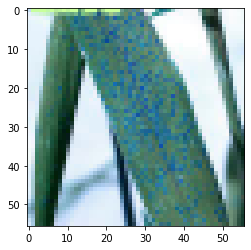

Crown and Root Rot
2.7963839841535065e-15
Fusarium Head Blight
1.3127083286990921e-18
Healthy Wheat
1.1532919584611445e-09
Leaf Rust
99.99048709869385
Tan Spot
0.009461447189096361
Wheat Loose Smut
4.983455141882587e-05
powdery mildew
1.744240446521772e-08
PREDICTION: LEAF RUST


In [ ]:
from keras.models import load_model
from collections import deque
from matplotlib import pyplot as plt
model_path = "/content/7wheat_deseases_Resent50_model.h5"
input = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFRUWGBgWFxcYFRUWFRgZFhgXGRcXFRUYHSggGBolGxgYITEhJSkrLi4uGB8zODMtNygtLisBCgoKDg0OGxAQGy0lICUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAOIA3wMBIgACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAABAgMEBQYHAAj/xAA+EAABAwICBwUFBQgDAQEAAAABAAIRAyEEMQUSIkFRYXEGgZGhsQcTMsHwQnKC0eEUIzNSYpKi8TRzsiRD/8QAGQEAAwEBAQAAAAAAAAAAAAAAAgMEAQAF/8QAMBEAAQMCBAMIAwEBAAMAAAAAAQACEQMhEjFBUWFx8BMiMoGRobHBBNHx4UIUM3L/2gAMAwEAAhEDEQA/ANeODCQfgVJBcpjTaU7tCFCVMI4Kv9q3EU2sP2nC3GAT6wr2WhUHt1iB75rR9ls95M/IJLqQaZXPqywhUzFVJJBN93ACf1TJxc0k5wYk85S+kBaOcErjLwNWMt2ZImT4QUiqwzJ5eWiQx4iANjzI6yyRDJ2o+HfBuNXWJ9VzKYmXGZvPE/6uupv1iZJyDehjehoG4btFrQRGcQLGdyTTeZB/sbqmoyxAMa8JgWHV0jiW7MiJZMyc5P6hdg6o4yQbkXjpKVe0OAJE7s46ZfVkixsQOHoTIPmnBhxEk2KDtW9mBFxfrmn1BzntDyIIJ9c/rinFS+ywSSQSJkjO/Ick3wesSW5zdsZ5XBKF2HaASCS42O6J4XuN/esdiLQALjj1nqtBZicSbaAC38AJ811JjWkaveO++adUJLSBLQ7KRuBmL5WEW+aa2ZqkkniYsTnBSoknWc8/FLb/AGYy6XK0vuGgc+Go61QhhgvJ5GJmJB+p22RqGkTQq++pEFzDz75G8ObI8VruB03SqYdmJLgxjhJkix3t5kHhmsgrtDQ8imAJJkHdPxfpyT/QXuXVqdPEA+6kxD3NAeYhxDd0QPNNo1nAcbZ2HNG8CIAteNTxuPVTXaftNUxDjQw4cGm2yCXu7hcDkm2iuxWJeLtFEHNzvjPRomO+FpWDwVOk3VpsawchE9TvTpGPwsTsVVxJ4W/34Sw/Dkq1ojsdh6NyDUdxdl4fmrAGxYWSkLoVTKTGCGiEMoiBHhFIRrlkPtOotpYgucdVtQSDzIv5hUqrUB1HEi4Iz7vktH9uWjS/C0q4zpv1T0eLeY81huJcbSbR4cVOBDiEDheVqPshxnu9IPpzatSP9zCHDy11tgXmLsDpE0sdh3k2FVoPR+wfJxXpxMbmUYyR0VwQoCjK5JhCgXJaNDKyztNipxFRwvLoHQQ35FaXjq+pTe/+VpPgFj2IBMm5vn5lJqHvAdbJdWA1N8dQI1CR8Qc4DllPko/C1LupkxbWb1YCYHVs+ATnGYs7LYn7M8AbqLrVy1/vIEg24S2I9FOe9LSN0towYX8jnfqylKmJOqG94dF9xBSLa5aBEga0Gc77/H1SmIvtCYdtt4QbxPLJJvNhmDJtHmldmALmL9e6c2sSYwzY/d+fFLUwdbVbecrc/wA0Qt1ZceBEcv0KClWBEQJEzHA5nrklKlMPIBOzEQTGWe10Rte7D7ciuLGh0OmM9yRz39MkfC5TMTaAb3O6d6PTeS34S5zTHCRHmMj3BMWML5iwkgx8UNMiCRZOsLXa393eZJB5G5tw/IJbzidOhtOu4VTBhYQLkEkjQaG9jBFiOSdCkZi0RdpO8cBkeaFlIga1QAOFwJtDhaw5T5JMkGXPzB1xHGcumXcn1n0iXS4Z6sWFpAEXA+IeCJ4IJ4X69FO02HG029jyN5z46NMQwu2JhvLM8BGXHyQVqVpvsxtDlkR6R3Ixe91PXbFiDAz1STdoN9yXe8aomzbkk8Cbx0KMFol0Zx/fL2uuPaS1si0wOIzFt/daH2E05+0UA13xslvMtFhnvFgeo4q0rF9C6Sfhqoc3LWBI3EXBHIEE/QWxYXENqMa9hlrhIKvom2E6fCAuxGUsuXLk5YuQEIVy5coTtjoz9owVelvLCW/ebtDzC866U7PvGHbWi1ut7fXRepCFkPaXBhgrYfc10t+6cvl4pFUQQ5bNlkmEpuY4GCOB57l6q0TixVoUqoyqMa/+5oPzXnjGN1mZX+e/zWy+y7G+80dRnOnrUz+Fx1f8S1b/ANBY02VuXIkrpRSiRVyBcShRKG7X1tXCVf6gG/3EBZ0x7QA2ASCXSeA3K99unf8AzgcXjykrOHPgmdwjxCmqXcSk1TkFG1DrOPGRbco3FUy4mImU/YQTM7yVG1XwCN7rFAZ/5zS2AFwxGApfRx1mOY4mae0BNtUxrR0MH8SM95DtrMRaPrJR2j8WaThUImDtDi02I8POFbdN6J1WsxNNwqUniQ/eS4bMg8RvS3yHSBz4EhNADmm9x7if1KgiW65EjVznumOu7qjVmSNUQYJIM5gW8wknMz3EePNLVKVw64gCBPK0oS1xIBM5SjD6YlwEG8a8vfVI0qGq7WmQ7dJgcB13yndKpAJnzEjjIzj9E21ZMd49R+S6NYlzhkT0M/7RBgbAaOgi7R1Ql1R3R4bbx76PajCSZ+ECLWJ+eS6mXNAh7iWjZG7OfoJrVrOLH5kiL5ndeU6pvdskGAeI3HescBiNpjK/r6aIu9gBkAEwfICN7nVPcL/Dc5xa5+Tb593IWSFGq4gNFgQYPC4z4TbzRGOAeMzEkXO+fzKGrU2S69hP19b0PZkAku7tkIqAuDQ3vT7/ABH+jJBimOLD/MLkC4JE5eavXs/0tb3Dt41m9b6zSOMX6hypVB4InMEJxo7Ee6rEiRBkHLcDItmCPI8VSzuukf2BHx8BB2hIggW+zPW0lbNK6Uy0bjBVpteN4uOB3/n0ITuVcHSJCxHXIkrpWyuRpVD7e4A+894PtNg9R+keCvcqA7ZUNbDkj7JHgbFBUEtWrEK7Ye5vG4+Y9PFX32L4qGYmh/K9tQfjGqf/AAPFUvTdItIdwN+hsfz7lL+yzF6mkHM3Vabh3tIcPIHxSWnujgVjLlbOSiF6AorgiJTQJSpQLiirVip/tArfwmc3OPkB81QsRVBM8/RWztvVnEx/K0DvMn5qlYp0CMiAZ6pBIPupqt3Jm10AnOxUc50vHinj3Qwydw81HUrP6D1uuAulhOMS4Bhzn/ZKsHZXTXvMBVwxg+6qAgkmzXbTf8g9veFVdJutyGaunsm0F77A418HWe5rW8ZptLoHXXhA5shydSmbbde6Yni7OZn6+rpamyeQ5mZjM/XFEqUZdDbxaYiwGa5pIBgAuyvvbN+mSneYZ3UdJpqP72p99fb6RajTZ2RzzFhMHpcSky4gxlN+XRLVKWrfOcznPG/eUjHXZMf77k5hlgJQOjGYy2SvvnxsAZ/DY62Unl/tPKwc4NkiYykWPDzlNS4W8zmIK40WueGtcdWHXMy7Mludo3dEp/dfbX24qqkBUpw6wbewz4E9egJQl5LSRNov3XB8PJHpWbe4yyzylKUwQyDaP8s5CTYDMbibI2GSbXySKktAbNsx/c9EvTeCSwFwyEi0ZZD6zRzUnbcb5zEeW63oupUpImBbOCJjId4nvXV4sQ4Fp3+krWghxg3I+Dn6LMQgW7s77i4njmtB7IaUpGmGiAbAmcyLfDuIsOYg71aVkWisVEsJie64FiOB4bslpmg9ICtT1gZLTqu6jj3QqKFQg4HeX2mSHCR15qR1l0oEEqiVkI0ptpGlr0nt4tMdcx5pdcuN1wWJ6dwus0uAsNlw8lB9lsX7rG4Z5Pw1Qx34tgnwMrSdJ6OHvKzNziQOsawPr4LJ9LUXUasixmejmn/SlGo3XRBBXpNFhJaPxAqUmVBk9rXD8QB+adAJwvdEUmilDKJWfDSeAJ8AuJWrL+0WJ18TWOe0QOghqrOkHQ09PmN6mMW83kXknnJUTjngtAjeFKBr1Cme6Tw+91G4qNQmeHjwTDBVLvHGPknWkgQAIiTZNMEBqvcTeckdksJlpepJgWEyt29kuD91oyjxqF1Q/icQP8QFguMeXEsGboA/LzXp3QeCFHD0aI//ADpsb4NAR08yqmXEzp6LPu2GC9ziXASGVNturaC47XW43bgFXJEQLWIdxGa07t1gPeYc1AJdSl3DZOfyPcVmljuuSJjOIGfNRVWllTh1ZFAAnXS8bX2/qJTbIDdYAATqkmbcOsoNqbRfZM3+jBSraYc8AXzE5WBub9ESqYEAGTJGU7Jt81jXMaC0nPLNaRUc7E0eEXmOjzQe4eGy4SN3fuPC+5DSbqiS4DaBGz/cD1slW4io5ha+NV0TfMCSBbLPLok8UxpaJNznlbmOaGZpgZHT1+U9siqZkj/qBpE24ap0yCSSdkCRN45DmR801Ltca4GpqmIO8RkEsaMsG0bATkDzOXUdCkqtMGGtJbckzJBncOGWXNcQQ/hPvmULSwsN+9BE6RcR52TlmIDACRNxfMA7geRyQ0nS0tgAC7QNxMl2ef6BImudUFoHwxa51hMyOmXcikTmIlonkTEgjkfVMuXHfT4jrgkQ0MAMQbGLneY3At6804pVQHBx2bR3iw8ePNWfsfpgU6urbVqEl1oggbz3eCqgp5AiacBp4nLOO9FdjIedQSGkXygHMQOKLtCCDrp11qhayBLTO+nLjOnpe63AoFGdmsf77DscTtAAHwBB72kHvUovQBxAEIkCFcjLViqPauiW1mVNxF+rf0Wbdu8Hm4C/xeH6ei1rthRmhrDNpB7jmsu02/ZAdeDE8uCneCHriQBC0T2a4z3ujqB3taWH8BLR5AK0BZ37G68Ua9An+HVkfde0R5tK0QJtPwrSkEw09W1MPVd/QfMQn6g+2dSMK/8AqLW+Lghf4Siyus0xT+KiMS7wJ9FKYx8Ptwy6qKxOYHVKN1Co7ST8gTNyR04KPwjtiTvJITnSdS45BMaBsBy9VlMBogaJjnFxLjmU/wCx+C/aNJUKcW941x6M2z/5XpmFhvsNwOvjK1Y5U2QDzefyafFbkE9uSeyzQi1KYcC1wkEEEcQbELGtL4A0KzqZN2uI7plpPULaQqH7StH/AAVhN9lwAzd9k94t3BK/IGEB22fI2/SLBjsM9FTXNmS6No7j6TvStOkC0hh1y3PiABcx3XPJNqLpIDrgEZ7s/wBUthaYaYkkxqybQHGTYZqLDUa6f7CzFTdTIJM58JPrwCSLG60AkGAb5C9z+iEYYOLqgIIaBYzvsSRxQ1gA4gGQCRMZgZfXNDQIAccybnuiM+c+KzCRBFxcp3aABwMgwB5Cx/xNntcRska32Rxzz5W8k7r4gxquaNY3lv2SOMdEhSaC4OqCAHbN7wLxHA/JKVawftNBHGxAI4+k9VrYL5Nieroqk9nhEODbE2zOxF41jzTZr4N7SPT0Sr6zyQIGqBM2HXmSiVtZ17Bo3c/1CNr3ESAMyeNpCY4guAMi/XkpmtIBIg2vwn75JRwc4E7vWN9kzrVSAQ2L+HNOcRRe10AwWTzngJ4c01xVpO/O3DL0ReLE1wQCGYXNMnaMvo2V39l+lCKj6DiYe2WTxZuH4T/itIWD6Dx7qWIpVAbU3TzI3jw1h3rdWvBAIuDcdCqaDs2nT4/so2jughHBRgUmjBPBXJtpahr0ajeLSsa0q2Rq8DELb1j/AGvwnu6zxuJPr9FLqjJC4WS3ssxOrjKjD/8ApT86bh8nHwWsSsN7I4v3eOouyGvq9zgW/MLcJQ0jmEYu0FFhVX2gVIosb/M/0BVthUb2h1tqm3g1x7yQPkiqGyx5hpVBxFQ65PAKNxBM6xva/eU9qu+MwTuUZiHXPQBTl0mOt1PECT5deqiNJVbu4AAR4JpUq7J6BK4oj94TuNus71H137J5lG2FpBAlbT7CNG6mFq1yCDVfqgnItYMx+IuHctRVf7BYH3Oj8NTiD7tpPVw1j5lT6cBAVURZHBUV2lwnvaDm78x1Ck0VwkQueMTSFwWK1KWYvIJmeWfn6pZv2Sb/AMwm8SpjtRg9SsQG603Am0X87qBFK5cZvbMRbK2f+15zTUyduheykDaRbLO/6ul61CC4CCAbkG14E+QTasCCA0B07geO4G10cUXOAj4dZpM8JvfpKWFEB17Tl/KYNp5c+aF5JEHII6MAgi7ttM8jO4umT6JDCHN6wYMxkCjYOoHNAYI1nEFpM3kTHLLvCbvqh0Ph2z9kbwRI6fol8M2SLhupDhO8ETq9bLMc9+P4nGnhb2bj/h2gZg2v75pPFuc1zhF9YtiIFt9+q5rHDZOU2Iyj9UvjATrFxJDnS13xOBO4gceqJSxTQA4nWiW32hqwRIWUc5OYQ/kXYA0CDawz62j2KB5cdoHaBAk9RE8tyLXY62tskghw6Eg5brSi1DLDqyRO0Bnw+uqXFY6ovEeuXpZOaZeXDh7qeoMNINdnJ5iDEb8eOiiJ1Tvt6f6W2di8f77CUyc2TTImfgs3/HVPesaxrwNbZyAiLzEXV79kuOvWoneBUaOmy7yLE6k8OeCOS4NczunW/XNaMhCFGCsXIQs89pGFh7X/AMw8wtCVY9oGF18OHDNjp8UNVstWG4WO1axp1GvGbXA+BlegMLVD2NeMnAEdCJWBY2lrFbB7PsXr4GlObJpn8JgeUJVOcXNcw90qxQs17d1tbEPG5rWt+fzWlrHu0+KLsRX++R4W+S6sYgLniWlVt1Sx5lNMTmesp5TblbfKia1TZceqXqplX8RUk33lBSoaz2MGb3AR950BExFawbwkqY9n+F99pHDMN/3gcejNr5JjQU1oGW69PYSlqsY0fZaB4CEquCFOhPRVy5csWqpdraM1GtFi8FrTEkHl3T4BUXF09WoYdNyOAO6eWavXtBDm0RVb8VMh46tII9FSce8Ete0ucx7Q4TmQ4Akgjl8lBUZFSY60RVCcNjEj1mxCPQpOJ1QQ0NBJsJJtsptWDRIEh0zqm8Dfqnf9cEDqp1Tqugm2e4xn4ozgJEHWGqWEuzBA4+HVTVGQ8zz62hHRqS0Ry5bToZP9Raz2uIYBtQSOYExbkAUxLid5EkHnIy809p4gUwXWJAIzE33tTSu4OdqxFiQRed8d3FNxtEtcbIGU6hhzGwR9FLe+qasapguLYAItJvfdqz4JGoIgbI3R0ySmFr6zQwkjXBGscg4GRa3AosgukAneP6hFvRKBDXEpzgXtEiJnSL8/URnkj0Q4Gw1eMW55JRziDIbJJERwJ2umco1F7iXQRYTcjI2Iub55JB9Obi8fXl8lUe83u5KCAx5D8x79ZpvXJ2i9u1k2+yReSY3z6KS7F480MZTvYvAcf6XNIM/3Nd+FR9Qt2QfiOt5R+fkmdOA6QSBviZiM/AoG27rdE8uNqjxnltGvoF6JCMo3QOO99h6VXe5gn7ws4f3AqQBXpgyJQIyZaaoh9B7TwT1FqM1mlvEEeKI3ELhYrBdLUtVxHNXT2QaR1m4inPwua/8AuEH/AMqn6bfFapSdm0keaDsrpL9nrF7bB7SHDmDKjBIgrKYhxaVvBCxbSzdZ9Y7zUf6lbU7JYniqw1altoveZ/EUdcXHn9LKh7qhaQO7cCoPFGGHoVY8JWsW2EjPoqtpA2f9b0qSXJEWUDUiJ35LQvYfgdfHmpupUye9xAHlKzqM1tHsG0ZFKtiTMucKY4Q258yqAn081rQRkRCjTUK5AEaFqxQnazDa+HeORWP6BxGvS926dbDvdTOXwOJcw/8Ato5NW54+lrU3DkvPtT9xpGpSNm1tjlrTNM/3DV/GVLVaCYTCTgt0NlO0GukAC1yOgsSN+5C6lDdS1ruImbxc84hFIkA5HInhmLjz8E5e2C4MILnCL7yLweH6qJ7yDLgP2Or+aFjQ4QwnOeXE5+2yYVAGlpu7huBi8ITSYATMwMt4kbXUXR8XSMatjkRE793PKe9Bh2042ydYSAe7/aItFnRl8dQtxOPdkmdt9o9Zi6j3m2qBvBG4SDB8lIAahDCCGgSHD4om4O43lNHAE3m2cJZtUOIOWrkB6GfHvK6swYxGqOg93ZunJvyeo80vSqO1pkXBIiLyLzz/AFRWkua5uWQJyg9PNEpOGsHEmLGQlWMJOsTrHW2RvPGSuNEt7szZJ/8AIB70AGZ6tt+wmGEcNvXNr25bxO5IvaQ1pixdBA32sE8xlDVvnJuDzyjzRdIw+m1wtkIk/EB8UfW9FTDgAeQXVXNc4zN5POcv99Vofsx0qXsqUXRIOuy+Y2Q+BwktP4ir0sP7E480MVRqEwxx1HfdMtz3AG/4FuCsoOGHDt/VxmAUK6UKa6QrarSU8nCJWBsmFiftPZ7rGmoMnX8c1AU8TJBGWfipv2iYoVnHi1UfRuK1XQcrqeJCF9nyF6vrGGk8j6LB6r5BPHWW5aSfFGoeDHehWD1HfuwOAW1/EORQVMgmdV0T0KrePcdQnjCnMYYaeiruk3bHgltzSQoxpXpb2W4D3OjaA3uBefxmfRebMJRL3NYM3ODR3kBeuNGYcU6NOmPssa3wEKgZqilqnC6EKEI0xcAhhcEDnwuWLqgsvPntXwupitcWneMwQbEc1u2JxcLGPa22XNPNTVHAuEJzBAKJgcY2rTZWFi8bQAsHNEOt94E96eUKzs3CwOfAjgPrJVrsVXmnWpxJaW1ByB2XnyZ5qcfijNrCLHjIuPD1U1Roc4A7pUOpyRFx556dZSlsXqgbHwyYz3ZE8zPckCZdJEA2kd3ndG9xlGUT9cUDyJAmRYmM4J8juRgNjDbZIBdJdec/9RCBMTbieSKSGho+WY3eCFzcxBmfoIDABymMzNp9FtQHDDdNEdItLiX6zf7S9G0kmInx5JN2ZvM2kGM96MCNUTMHZkeRE80pUpyI1NUZCN8DdHWeqDHjeQcslpp9mwOFjnplpHI57IlWiGthwJIkXNxJ3RwUcQbhP23kmJJygiDaT8+9Nq7NUtMjazHTce5bTIY2DZZUmo8kEmNesrlR2IMNcJgRI8b/AD8VvPY/Sn7ThKVUmXauq/77bOPfn3rD8dEugEXNjuO8K8eyHShFSrhydlzRUYODm7Lx3t1f7E+lGLEMijm2A5hamq92rxWrTPRT5KovtAxMUym1TZGzUrJcdiNao/nZVrHs1X2Usam1PNNNKUt6AKe5C9QaYf8A/PV+470Kwiq7ZW5afMYat/1u9Fh+psE7ohDVPe8vtdWGXn9KLx7tk9FA6RfDIGRKmtIEap42Vaxr5tzWNuUpphTns7wHvsfh2RI19Y9GbXyC9QLB/YbgdbGPqxanTt1cfyBW7Fyc1VMHdQyhlIOrAJtXxwC4uARhpKeVKwCi8XjtwUXpHSyhhpBzjZJdUJTAGtVhY4uKo/tU0afda/C6uWj6nFRPtBcHYZ3QpcI4ssn9nVQftoYcqjXMPeOCsWJoFhcwyHMcQ4Ra1vWypXZ+v7vFUn8HBaj2uwX7xmIb8FVo1uAc2AZ6iD1lFUnRJe1sSRkofBVriZjIgb/qShxNUNdAi2Rt58RySFNxNgLxfOOqO7aHSZ7rFIBmoDp1PXFJLQ1nG2uWo/3aEfCYg6+t9oHWJz35+KCsJLrbMkbs98RmJSGGdDpiRkR6eKf4sMdDdoRBuMoPru8Vz6mGoPjdFTZiaSRbfUeXOFG4aoQb/ZItOdxkPNSTsU7VLmkb92ccJ3wfJNXtIMjfbxT+jgveNkEyATAndBdI32MrH0IJvn11zTh+SHBstmPWL78/YJi4E7RM8T32POyQqsBvOX1MfWac1si0RBFo8Y5Ju+pIneREdBuTmsIgEWCjc8XcDBMz1smtQmZmeFrjjP1uRtBaUOFr06wBIpvBMfyOBa4ecd66oPO/fwTSsSJIMS0tymzgb+fjCYaeFuFumS1lWX4na5r0drWkLM/aVU2SrP7PtJGvgKRcZfTHun3m7LAnmW6p71VvaO2WlMqGQFQPCVlAzSmOpy1C+gUu4bMrgFO269DdpT/8lf8A63eiw2rW/dkdFuPac/8AyV/+t3osGrO2T3IKglx5fa2tomWkG7Eyq1iHAu71P6Srwwjoq39pdTmSkhbR7FKXu6Nap/M4D+0fqtBxGPhU/sJg/c4KnxcNY9908x9ZyW4mYXoNENCdYzTUb0yGOc9RrMEXOurJozRgEWWImlzkzZgC/NPKGio3KfoYYBOBTCMMK2WhQjcIQoztLgC6g4RuVwFMJDSFAGm4ckRp2XB4mF5YxTdSqRva70K3TRuG/acBq5nVDm8dZuUdbjvWM9q8PqYqoOcrcPZdXD8IzpCEAOACwReVntV5a4WItcGRn+icNaY9XbrjI+BKl+3WiPdYh7m/BUHvG57yA9o6G8cCq7hHXg5TfgkmmMJLvNSFzg8Nbvbr6y4JxhaVzv1RPUZAgHqE8e4lhJj+WcjvP5hNiMnA2uO7Ig+KVo1B8JGzM+vDfeUp4M9oLgdH2TGFpHZkQ4ze3l9e+9kXguBBzQYCo73jHCxab3OW+/HMd6M8EG4uLH6+skg5xDp3H9FWWCo2EmnVdTJLc/3mlsQ0NEEiTBbFzvseB5JjUBz4p5VpmJ5T0Teu4lpAixnnzCy44pctMDK3r+khUFvNN6jZBG4jz3J1Vjde0psbA3gz6og8YQZRYHAxF+j8K5ex3ShbVrYV32m+8b95lnd5aQfwqd7aYXWlZpoTS5w+Pw9Y5azGOP8ASf3biejD5Ba72mp5rdLqgRhMLMMRo8AKIxdPVsrdi2KsaaHBaCpxmtq7TYofs9YcWO9FiLzDY4rR9O4smlUP9JWZYl+xZKJJk8E38iJaFFaacAyN8qHwdPXe1vFwHiU90o46sEzdL9lsNr4qkAPtA+CZTs26WYcYAW+0WhlJjRuaB5JjUbJ5py1pKfYTBbyk5lX5pDR+B3lTtClC6hRhOA1PYyLrHO0QAI4CEBDCaAlErgEWq2QQjoCtWSvOvtLwupiyeKvXsWxc0CzgSFX/AGy4aKrXI3sSxkVKjOYKmZYciqHeKN1pfb3R/vcKXwdakdcRnq5PHSLnosppyO+18uUrdMS9urDrgiCDkQcwsa09ov8AZqrqYMtmWznqn4Z7rLarGknipKmJoa8aJJrb6sGMu7olKrCyxG4O7nAEHwR6EubIO0Dx+t4CFwa5hJO00+Id8XcCP8kDDhskuH+TqgG0e6fzPh6JnXFiN4KPSqQfTuXPGvrOGzAHSTw8vFc6oGEA6rGUy4EjT18kWm4uYQDBIzSNV7RAE55nghFQCGjOSJ5nIeqNiXa2YiReIEGdyAukksz/AFonBpaG9p4cxvfUbxGRTRzIMcPMQm9Xid+fcnbm2nhY/JEqtm25UAAWU0yobSlLWbllZa83S4xGFpVd76bSfvAQ/wDyBWZuDQwh2fwkRyN+UEDxU12RxY93UoB2sKbyWHiypcHxDkOIOMKloc1s6GyksW5VTSr7lWTFnNVHSz9pc2Q6UEiFr2ktHxhav3CsdxrthegNM0h+z1RxY70XnzE3YV0QSOH2j/JvHmoXSTrK1+yrCe9xTjHwM9SFUcetL9heGk4ip91vqUYEhBR8YWnYfDKRpU4QNbCXpNXNYrXGAjNajIUCbCWjBCgXLYQrkVGKKsWhZV7Z8LNMO4FUf2VYvUxoH8w9Fq3tSwevhnW3LEOyeI93jKTv6o8VPq4JpPhK9KabvRJHBZ/pZ37TQ963+JR2XjeWT8j6laJ8dDuWT0cd+z41zT8DzBHWyXWMOB3QuAiDyTUs2iLjLKxIz3oTAgCYi8/mneIwThWc0uBMjUm0tzB6EEHxUeCb3kDMmchu4rGlp7xEH9KRzX+ASQPk9Ecc0YRHT5o7aetLZzB/PPuSRIMmIEgR3ZoWgxzCYQ2ozggBdTfIzCScwyBAkxcjIkC4TjDtBIBEybngRbJGxBL4icgDyIt52K7R5AfDhEHakbxnISrlpMxGe9vqE0Q0x4py2uMufnYpF1IBxBy/PIwmobxUk/J7YAO6crJlVG1yOfVOY4mZHnvZJe0ADzttCZPpbZJOy6I5H5/olOzlQMxFsnhzDwkS4d8tPihxlEubnBEHw4hMS73ZDwPhcHGN8EE+i4MINstOvX0TcbXCTmczx6gq0411iqXpWptK5aROzKpGkDtFGUtq9F6X/hP+6fRYBU/hv+t65clVfF1uqauY8/hQGJyK1n2D/wACv98f+QuXJzdUul4vJagE4ZkhXIwnlCgXLkRWLkZAuXBYUKBcuWrlW+3f/Gf0K84YL/kU/vj1XLlOfGeSM+EL0/oj/jj7vyWOdtP+UVy5TfkeFvmtq5HmrA0S/DTf92/O+4qFq/HU5zPO+9CuXDPyPwVNU8Xp9JFuSWp5rlypb4etlMevVK4LMdR6Bdpb+PV+98iuXJD8/JVUPCf/AKb9pJn5/wDpIYrf94/NcuRfj+BvIfSV+R/7n8z8pF3yKjam/ofmuXKjRJbkp9//AB6f/Wz/AMhUvF/EUK5Cck0Zr//Z"
label = "/content/lb"
# load the trained model and label binarizer from disk
moodel = load_model(model_path)
lb = pickle.loads(open(label, "rb").read())
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input)
(W, H) = (None, None)
ii=0
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    text = "PREDICTION: {}".format(label.upper())
    cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_SIMPLEX,0.25, (200,255,155), 2)
    # show the output image
    image=cv2.resize(output,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    plt.show()
    for i in range(0,7):
     print(lb.classes_[i])
     print(results[i]*100)
    print(text)
    key = cv2.waitKey(10) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
vs.release()

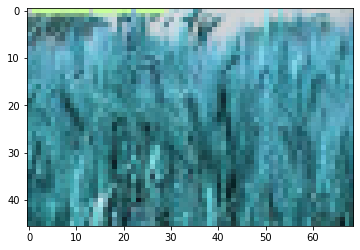

Crown and Root Rot
4.376669027195135e-08
Fusarium Head Blight
1.2241644143821473e-13
Healthy Wheat
99.99994039535522
Leaf Rust
1.4985424359736932e-09
Tan Spot
1.0873047694680022e-12
Wheat Loose Smut
5.5193663683894556e-05
powdery mildew
5.593747096181978e-19
PREDICTION: HEALTHY WHEAT


In [ ]:
from keras.models import load_model
from collections import deque
from matplotlib import pyplot as plt
model_path = "/content/7wheat_deseases_Resent50_model.h5"
input = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQTGGdC260U-qHLMkl9wN-nHlkAu-HJr1DvA&usqp=CAU"
label = "/content/lb"
# load the trained model and label binarizer from disk
moodel = load_model(model_path)
lb = pickle.loads(open(label, "rb").read())
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input)
(W, H) = (None, None)
ii=0
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    text = "PREDICTION: {}".format(label.upper())
    cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_SIMPLEX,0.25, (200,255,155), 2)
    # show the output image
    image=cv2.resize(output,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    plt.show()
    for i in range(0,7):
     print(lb.classes_[i])
     print(results[i]*100)
    print(text)
    key = cv2.waitKey(10) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
vs.release()

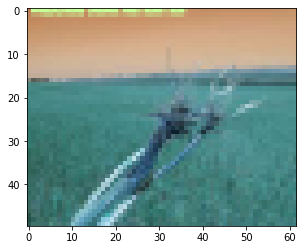

PREDICTION: CROWN AND ROOT ROT


In [ ]:
from keras.models import load_model
from collections import deque
from matplotlib import pyplot as plt
model_path = "/content/7wheat_deseases_Resent50_model.h5"
input = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQQ76Vemk1gzUE5wS7X0yItKnRBcyAiOLYW4A&usqp=CAU"
label = "/content/lb"
# load the trained model and label binarizer from disk
moodel = load_model(model_path)
lb = pickle.loads(open(label, "rb").read())
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)
vs = cv2.VideoCapture(input)
(W, H) = (None, None)
ii=0
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    text = "PREDICTION: {}".format(label.upper())
    cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_SIMPLEX,0.25, (200,255,155), 2)
    # show the output image
    image=cv2.resize(output,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    plt.show()
    print(text)
    key = cv2.waitKey(10) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
vs.release()